# Optional Assigment - BBC news archive
This week you will build on last week’s exercise where you tokenized words from the BBC news reports dataset. This dataset contains articles that are classified into a number of different categories. See if you can design a neural network that can be trained on this dataset to accurately determine what words determine what category. Create the vecs.tsv and meta.tsv files and load them into the embedding projector.

##### Copyright 2019 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

**Note:** This notebook can run using TensorFlow 2.5.0

In [1]:
import re
import time
import pandas as pd
import numpy as np
import nltk
from nltk import *
import json

import random
random.seed(10)

from joblib import dump, load

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score

# Ejemplo con Stack de RNNs
from keras.layers import Embedding, SimpleRNN
from keras.layers import Dense, Flatten, GlobalAveragePooling2D, LSTM, SpatialDropout1D
from keras.models import Sequential, load_model
from keras.losses import SparseCategoricalCrossentropy

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score #son metricas - area debajo de la curva roc

from sklearn.model_selection import train_test_split




In [2]:
import csv
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# bbc-text.csv
# !gdown --id 1rX10xeI3eUJmOLsc4pOPY6AnCLO8DxNj

In [3]:
with open("cvectorizer_vocabulary_.json", mode = "r", encoding = "latin-1", ) as f:
    cvectorizer_vocabulary_ = json.load(f)

In [4]:
vocab_size = len(cvectorizer_vocabulary_)
embedding_dim = 32
max_length = 20
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'
training_portion = .7

In [36]:
corpus_esA = pd.read_csv("tweets_search_etiquetas_clean.csv", sep = ";", encoding = "latin-1")
idA = corpus_esA[corpus_esA.columns[0]]
#X_textA = list(corpus_esA[corpus_esA.columns[3]].fillna(' ').values)
#y_hsA = corpus_esA[[corpus_esA.columns[5], corpus_esA.columns[6], corpus_esA.columns[7]]].values
y_hsA = corpus_esA[[corpus_esA.columns[5]]].values
#y_hsA = np.array(list(map(lambda x: list(x), list(y_hsA))))
#y_hsA = np.char.mod('%d', y_hsA)
corpus_esA.tail()


,id_str,created_at,screen_name,text,user_followers,sentiment,funcionality,client_attention,sentiment_code
311,153653000000000,Tue Jun 20 01:55:56 +0000 2022,pruebaTrainDummy,colores fotos huawei estan saturados malos,1,0,1,0,1
312,153653000000000,Tue Jun 20 01:55:56 +0000 2022,pruebaTrainDummy,contento huawei colores estan saturados,1,0,1,0,1
313,155237976078913,Wed Jul 27 19:45:51 +0000 2022,unamushasha,si huawei varian datos ejemplo dice dormi xd,2088,0,1,1,5
314,15523789805773,Wed Jul 27 19:42:45 +0000 2022,Andre_Villalba,buen teléfono huawei android malo so propietar...,358,1,1,0,3
315,155237713161064,Wed Jul 27 19:35:24 +0000 2022,loboalonsotegui,llevo huawei pesar fallos mu tontos ahí sigue ...,132,1,1,0,3


In [37]:
corpus_train_esA, corpus_dev_esA = train_test_split(corpus_esA, test_size=0.3)


In [38]:
train_idA = corpus_train_esA[corpus_train_esA.columns[0]]
X_train_textA = list(corpus_train_esA[corpus_train_esA.columns[3]].fillna(' ').values)
#y_train_hsA = corpus_train_esA[[corpus_train_esA.columns[5], corpus_train_esA.columns[6], corpus_train_esA.columns[7]]].values
y_train_hsA = corpus_train_esA[[corpus_train_esA.columns[5]]].values
#y_train_hsA = np.array(list(map(lambda x: list(x), list(y_train_hsA))))
#y_hsA = list(y_hsA)

test_idA = corpus_dev_esA[corpus_dev_esA.columns[0]]
X_test_textA = list(corpus_dev_esA[corpus_dev_esA.columns[3]].fillna(' ').values)
#y_test_hsA = corpus_dev_esA[[corpus_dev_esA.columns[5], corpus_dev_esA.columns[6], corpus_dev_esA.columns[7]]].values
y_test_hsA = corpus_dev_esA[[corpus_dev_esA.columns[5]]].values
#y_test_hsA = np.array(list(map(lambda x: list(x), list(y_test_hsA))))
#y_hsA = list(y_hsA)

y_train_hsA

array([[0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
    

In [39]:
import random
train_size = int(len(X_textA) * training_portion)

X_train_textA = X_textA[0:train_size]
y_train_hsA = y_hsA[0:train_size]

X_test_textA = X_textA[train_size:]
y_test_hsA = y_hsA[train_size:]
"""
print(train_labels[0:10])
print(train_sentences[0])
print(len(train_labels))
print(len(validation_sentences))
print(len(validation_labels))
"""

'\nprint(train_labels[0:10])\nprint(train_sentences[0])\nprint(len(train_labels))\nprint(len(validation_sentences))\nprint(len(validation_labels))\n'

In [40]:
# propio
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_textA)
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(X_train_textA)
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
"""
print(train_sequences[0])
print(train_padded[0])
print(len(train_sequences[0])) # <class 'list'>
print(len(train_padded[0])) # <class 'numpy.ndarray'>

print(len(train_sequences[1]))
print(len(train_padded[1]))

print(len(train_sequences[10]))
print(len(train_padded[10]))
"""

"\nprint(train_sequences[0])\nprint(train_padded[0])\nprint(len(train_sequences[0])) # <class 'list'>\nprint(len(train_padded[0])) # <class 'numpy.ndarray'>\n\nprint(len(train_sequences[1]))\nprint(len(train_padded[1]))\n\nprint(len(train_sequences[10]))\nprint(len(train_padded[10]))\n"

In [59]:
word_index

{'<OOV>': 1,
 'huawei': 2,
 'p': 3,
 'si': 4,
 'pro': 5,
 'bien': 6,
 'celular': 7,
 'teléfono': 8,
 'app': 9,
 'google': 10,
 'ver': 11,
 'servicio': 12,
 'tener': 13,
 'tienda': 14,
 'nova': 15,
 'iphone': 16,
 'hace': 17,
 'dos': 18,
 'watch': 19,
 'samsung': 20,
 'mejor': 21,
 'xiaomi': 22,
 'clientes': 23,
 'años': 24,
 'bueno': 25,
 'lite': 26,
 'así': 27,
 'después': 28,
 'servicios': 29,
 'ahora': 30,
 'nuevo': 31,
 'primero': 32,
 'cosa': 33,
 'van': 34,
 'nueva': 35,
 'puedo': 36,
 'buena': 37,
 'pantalla': 38,
 'llegó': 39,
 'sigo': 40,
 'gracias': 41,
 'chiste': 42,
 'atrás': 43,
 'menos': 44,
 'hola': 45,
 'cámara': 46,
 'puede': 47,
 'camara': 48,
 'esperando': 49,
 'solo': 50,
 'ofrecen': 51,
 'echan': 52,
 'nota': 53,
 'pues': 54,
 'días': 55,
 'apps': 56,
 'comprar': 57,
 'gama': 58,
 'android': 59,
 'nunca': 60,
 'directo': 61,
 'd': 62,
 'buenos': 63,
 'rapido': 64,
 'sigue': 65,
 'hacer': 66,
 'm': 67,
 'software': 68,
 'usar': 69,
 'usuarios': 70,
 'prometen': 71,


In [41]:
train_sequences

[[1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 2, 30, 1, 1, 1, 1, 1, 2, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 40, 49, 1, 15, 1, 41, 1, 1, 1, 1, 2, 50, 1, 1, 1, 1, 1, 1, 23],
 [2, 1, 1, 1, 1, 1],
 [1, 2, 1],
 [1, 1, 1, 2, 1],
 [1, 2, 3, 26, 1, 10, 1, 1, 1, 30, 16, 1, 1, 1],
 [1, 1, 2],
 [1, 1, 1, 1, 1, 2, 1],
 [1, 7, 2, 3, 1, 27],
 [6, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 7, 1, 1, 2, 31, 1, 1, 1],
 [23, 42, 2, 32, 51, 33, 28, 52, 43, 53],
 [2, 3, 5, 1, 1, 1, 1, 1, 1, 1, 41],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 5, 1, 1, 1, 1, 17, 1, 1, 1, 1, 1],
 [1, 1, 1, 8],
 [1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1],
 [1, 2, 17, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [34, 18, 1, 40, 49, 1, 2, 1, 1, 1, 1, 8],
 [23, 42, 2, 32, 51, 33, 28, 52, 43, 53],
 [2, 19, 1, 1],
 [1, 20, 1, 1, 2, 1, 1],
 [18, 1, 4, 1, 1, 1, 54, 21, 1, 54, 1, 1, 22, 20, 2, 1, 1, 1, 44],
 [17, 55, 1, 1, 1, 1, 1, 1, 1, 2, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1

In [42]:
train_padded

array([[ 1,  1,  1, ...,  0,  0,  0],
       [ 1,  1,  1, ...,  0,  0,  0],
       [ 1,  2, 30, ...,  0,  0,  0],
       ...,
       [ 1,  1,  1, ...,  0,  0,  0],
       [ 2,  1,  2, ...,  0,  0,  0],
       [ 1,  1,  1, ...,  1,  1, 25]])

In [43]:
type(train_padded[0][0])

numpy.int32

In [45]:
# propio
validation_sequences = tokenizer.texts_to_sequences(X_test_textA)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length)

print(len(validation_sequences))
print(validation_padded.shape)

# Expected output
# 445
# (445, 120)

95
(95, 20)


In [46]:
y_hsA

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
    

In [47]:
# propio
#label_tokenizer = Tokenizer(num_words=6)
#label_tokenizer.fit_on_texts(y_hsA) # labels y_hsA

training_label_seq = pad_sequences(y_train_hsA, padding=padding_type, truncating=trunc_type) # train_labels y_train_hsA
validation_label_seq = pad_sequences(y_test_hsA, padding=padding_type, truncating=trunc_type)

print(training_label_seq[0])
print(training_label_seq[1])
print(training_label_seq[2])
print(training_label_seq.shape)

print(validation_label_seq[0])
print(validation_label_seq[1])
print(validation_label_seq[2])
print(validation_label_seq.shape)

# Expected output
# [4]
# [2]
# [1]
# (1780, 1)
# [5]
# [4]
# [3]
# (445, 1)

[0]
[0]
[0]
(221, 1)
[1]
[0]
[0]
(95, 1)


In [20]:
# original
#label_tokenizer = Tokenizer(num_words=6)
#label_tokenizer.fit_on_texts(labels) # labels y_hsA

#training_label_seq = pad_sequences(label_tokenizer.texts_to_sequences(train_labels), padding=padding_type, truncating=trunc_type) # train_labels y_train_hsA
#validation_label_seq = pad_sequences(label_tokenizer.texts_to_sequences(validation_labels), padding=padding_type, truncating=trunc_type)



In [36]:
for i in train_padded:
    if type(i) is np.ndarray:
        print(type(i[0]))
    break

<class 'numpy.int32'>


In [48]:
y_train_hsA

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
    

In [49]:
# propio

# categorical_crossentropy (cce) produces a one-hot array containing the probable match for each category,
# sparse_categorical_crossentropy (scce) produces a category index of the most likely matching category.
# binary_crossentropy: 

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 16, input_length=max_length),
    tf.keras.layers.GlobalAvgPool1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid') # softmax para multiclase
])
#model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

print(model.summary())

num_epochs = 10
history = model.fit(train_padded, y_train_hsA, epochs=num_epochs, verbose=2) #validation_data=(validation_padded, validation_label_seq) y = training_label_seq


# evaluate the model
scores = model.evaluate(train_padded, y_train_hsA, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[0], scores[0]*100))

loss, accuracy = model.evaluate(train_padded, y_train_hsA, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
#loss, accuracy = model.evaluate(X_test_cvectorized, y_test_hsA, verbose=False)
#print("Testing Accuracy:  {:.4f}".format(accuracy))
#plot_history(history)

# make predictions
testPredict_stackRNN = model.predict(validation_padded)
print('\t', 'Accuracy', accuracy_score(y_test_hsA, testPredict_stackRNN.round()))

# Expected Output
# Layer (type)                 Output Shape              Param #   
# =================================================================
# embedding (Embedding)        (None, 120, 16)           16000     
# _________________________________________________________________
# global_average_pooling1d (Gl (None, 16)                0         
# _________________________________________________________________
# dense (Dense)                (None, 24)                408       
# _________________________________________________________________
# dense_1 (Dense)              (None, 6)                 150       
# =================================================================
# Total params: 16,558
# Trainable params: 16,558
# Non-trainable params: 0

c:\Users\histe\Documents\formacion\data_science_IA\proyecto_twitter_tech_sentiment_analysis\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_3      │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
7/7 - 1s - 107ms/step - accuracy: 0.8190 - loss: 0.6637
Epoch 2/10
7/7 - 0s - 9ms/step - accuracy: 0.8190 - loss: 0.6068
Epoch 3/10
7/7 - 0s - 6ms/step - accuracy: 0.8190 - loss: 0.5531
Epoch 4/10
7/7 - 0s - 6ms/step - accuracy: 0.8190 - loss: 0.5148
Epoch 5/10
7/7 - 0s - 6ms/step - accuracy: 0.8190 - loss: 0.4888
Epoch 6/10
7/7 - 0s - 5ms/step - accuracy: 0.8190 - loss: 0.4733
Epoch 7/10
7/7 - 0s - 5ms/step - accuracy: 0.8190 - loss: 0.4686
Epoch 8/10
7/7 - 0s - 5ms/step - accuracy: 0.8190 - loss: 0.4685
Epoch 9/10
7/7 - 0s - 5ms/step - accuracy: 0.8190 - loss: 0.4685
Epoch 10/10
7/7 - 0s - 5ms/step - accuracy: 0.8190 - loss: 0.4686
loss: 46.79%
Training Accuracy: 0.8190
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
	 Accuracy 0.3368421052631579


In [50]:
y_train_hsA

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
    

In [51]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 16, input_length=max_length),
    tf.keras.layers.GlobalAvgPool1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

num_epochs = 10
history = model.fit(train_padded, y_train_hsA, epochs=num_epochs, verbose=2) #validation_data=(validation_padded, validation_label_seq) y = training_label_seq



# evaluate the model
scores = model.evaluate(train_padded, y_train_hsA, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[0], scores[0]*100))

loss, accuracy = model.evaluate(train_padded, y_train_hsA, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
#loss, accuracy = model.evaluate(X_test_cvectorized, y_test_hsA, verbose=False)
#print("Testing Accuracy:  {:.4f}".format(accuracy))
#plot_history(history)

# make predictions
testPredict_stackRNN = model.predict(validation_padded)
print('\t', 'Accuracy', accuracy_score(y_test_hsA, testPredict_stackRNN.round()))

c:\Users\histe\Documents\formacion\data_science_IA\proyecto_twitter_tech_sentiment_analysis\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_4      │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
7/7 - 1s - 91ms/step - accuracy: 0.7602 - loss: 0.6754
Epoch 2/10
7/7 - 0s - 5ms/step - accuracy: 0.8190 - loss: 0.6350
Epoch 3/10
7/7 - 0s - 5ms/step - accuracy: 0.8190 - loss: 0.5926
Epoch 4/10
7/7 - 0s - 5ms/step - accuracy: 0.8190 - loss: 0.5507
Epoch 5/10
7/7 - 0s - 5ms/step - accuracy: 0.8190 - loss: 0.5147
Epoch 6/10
7/7 - 0s - 5ms/step - accuracy: 0.8190 - loss: 0.4912
Epoch 7/10
7/7 - 0s - 5ms/step - accuracy: 0.8190 - loss: 0.4767
Epoch 8/10
7/7 - 0s - 5ms/step - accuracy: 0.8190 - loss: 0.4693
Epoch 9/10
7/7 - 0s - 5ms/step - accuracy: 0.8190 - loss: 0.4696
Epoch 10/10
7/7 - 0s - 5ms/step - accuracy: 0.8190 - loss: 0.4686
loss: 46.84%
Training Accuracy: 0.8190
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
	 Accuracy 0.3368421052631579


In [52]:
testPredict_stackRNN

array([[0.16549613],
       [0.17434189],
       [0.15683325],
       [0.15018117],
       [0.17583872],
       [0.16405469],
       [0.17434189],
       [0.16426954],
       [0.15284576],
       [0.15554896],
       [0.18730025],
       [0.21024114],
       [0.15002449],
       [0.16389275],
       [0.17095211],
       [0.1697216 ],
       [0.14755498],
       [0.2406072 ],
       [0.18717392],
       [0.19863647],
       [0.1702352 ],
       [0.16892143],
       [0.15782242],
       [0.17114666],
       [0.23675446],
       [0.16753095],
       [0.15780784],
       [0.15595669],
       [0.17392296],
       [0.19086574],
       [0.15943705],
       [0.18268079],
       [0.16219085],
       [0.16027097],
       [0.16437253],
       [0.1707959 ],
       [0.16330643],
       [0.1477907 ],
       [0.16834514],
       [0.1809144 ],
       [0.17598866],
       [0.16725771],
       [0.17572877],
       [0.18805447],
       [0.17884718],
       [0.16598386],
       [0.16930647],
       [0.173

In [53]:
y_test_hsA

array([[1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
    

In [55]:
history.history["val_loss"]

KeyError: 'val_loss'

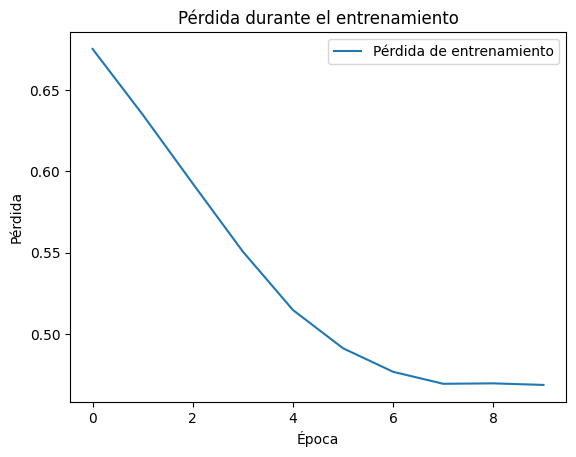

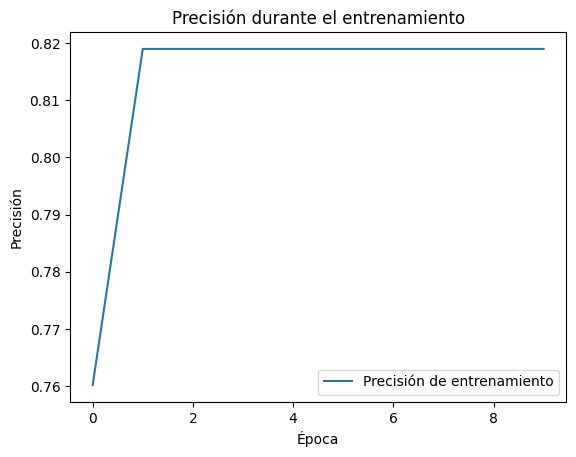

In [56]:
import matplotlib.pyplot as plt

history_dict = history.history

# Grafica la pérdida
plt.plot(history_dict['loss'], label='Pérdida de entrenamiento')
#plt.plot(history_dict['val_loss'], label='Pérdida de validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.title('Pérdida durante el entrenamiento')
plt.show()

# Si tienes métricas como accuracy:
plt.plot(history_dict['accuracy'], label='Precisión de entrenamiento')
#plt.plot(history_dict['val_accuracy'], label='Precisión de validación')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()
plt.title('Precisión durante el entrenamiento')
plt.show()

In [63]:
#original

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 16, input_length=max_length),
    tf.keras.layers.GlobalAvgPool1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(6, activation='sigmoid')
])
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

num_epochs = 15
history = model.fit(train_padded, training_label_seq, epochs=num_epochs, verbose=2) #validation_data=(validation_padded, validation_label_seq) y = training_label_seq



# evaluate the model
#scores = model.evaluate(train_padded, y_train_hsA, verbose=0)
#print("%s: %.2f%%" % (model.metrics_names[0], scores[0]*100))

#loss, accuracy = model.evaluate(train_padded, y_train_hsA, verbose=False)
#print("Training Accuracy: {:.4f}".format(accuracy))
#loss, accuracy = model.evaluate(X_test_cvectorized, y_test_hsA, verbose=False)
#print("Testing Accuracy:  {:.4f}".format(accuracy))
#plot_history(history)

# make predictions
#testPredict_stackRNN = model.predict(validation_padded)
#print('\t', 'Accuracy', accuracy_score(y_test_hsA, testPredict_stackRNN.round()))

# Expected Output
# Layer (type)                 Output Shape              Param #   
# =================================================================
# embedding (Embedding)        (None, 120, 16)           16000     
# _________________________________________________________________
# global_average_pooling1d (Gl (None, 16)                0         
# _________________________________________________________________
# dense (Dense)                (None, 24)                408       
# _________________________________________________________________
# dense_1 (Dense)              (None, 6)                 150       
# =================================================================
# Total params: 16,558
# Trainable params: 16,558
# Non-trainable params: 0

c:\Users\histe\Documents\formacion\data_science_IA\proyecto_twitter_tech_sentiment_analysis\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_7      │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/15


ValueError: Argument `output` must have rank (ndim) `target.ndim - 1`. Received: target.shape=(None, 3), output.shape=(None, 6)

In [178]:
numpy.ndarray([1.0]) == numpy.ndarray

TypeError: 'float' object cannot be interpreted as an integer

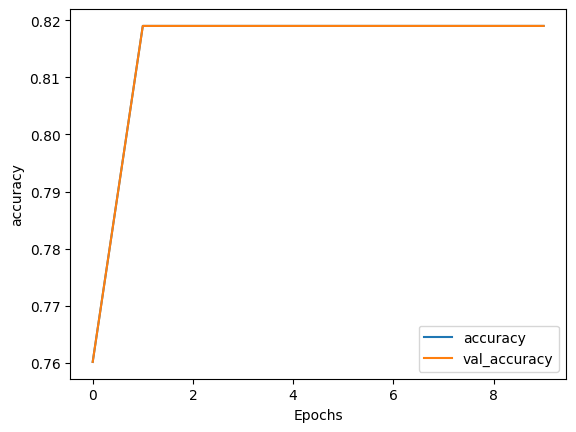

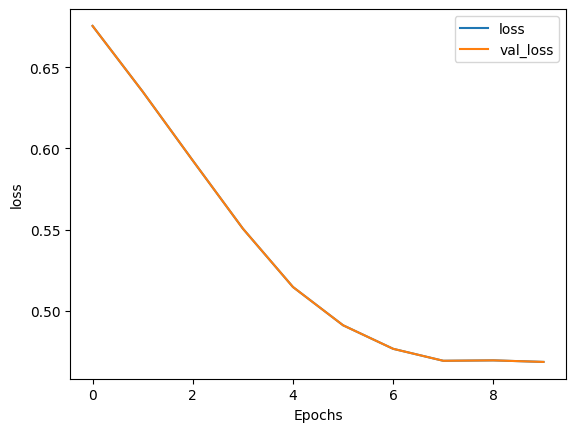

In [58]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history[string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

reverse_word_index

{1: '<OOV>',
 2: 's',
 3: 'said',
 4: 'will',
 5: 'not',
 6: 'mr',
 7: 'year',
 8: 'also',
 9: 'people',
 10: 'new',
 11: 'us',
 12: 'one',
 13: 'can',
 14: 'last',
 15: 'first',
 16: 't',
 17: 'time',
 18: 'two',
 19: 'world',
 20: 'government',
 21: 'now',
 22: 'uk',
 23: 'years',
 24: 'no',
 25: 'best',
 26: 'just',
 27: 'make',
 28: 'told',
 29: 'get',
 30: 'film',
 31: 'like',
 32: 'game',
 33: 'made',
 34: 'back',
 35: 'music',
 36: 'many',
 37: 'three',
 38: '000',
 39: 'labour',
 40: 'next',
 41: '1',
 42: 'bbc',
 43: 'well',
 44: 'set',
 45: 'number',
 46: 'take',
 47: 'way',
 48: 'added',
 49: 'market',
 50: '2',
 51: 'may',
 52: 'says',
 53: 'company',
 54: 'home',
 55: 'election',
 56: 'off',
 57: 'good',
 58: '2004',
 59: 'going',
 60: 'party',
 61: 'still',
 62: 'games',
 63: 'much',
 64: 'england',
 65: 'win',
 66: '6',
 67: 'go',
 68: 'work',
 69: 'since',
 70: 'firm',
 71: 'second',
 72: 'show',
 73: 'top',
 74: 'blair',
 75: 'won',
 76: 'think',
 77: 'week',
 78: 'use

In [ ]:
import io

out_v = io.open('output/vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('output/meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()